In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from tqdm.notebook import tqdm
rng = np.random.default_rng()

In [2]:
# Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [3]:
train_imgs = train_data[:, 1:]  # (60000, 784)
test_imgs = test_data[:, 1:]  # (10000, 784)
train_labels = train_data[:, 0]  # (60000, )
test_labels = test_data[:, 0]  # (10000, )

In [4]:
# Change the top k input values to 1, rest of the values to 0
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [5]:
from scipy.signal import convolve
# k-cap on convolved input pixels
cap_size = 200
n_examples = 5000
examples = np.zeros((10, n_examples, 784))
for i in range(10):
    examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)

In [35]:
n_in = 784
n_neurons = 2000
n_out = n_neurons
sparsity = 0.1
num_learn_area = 3
n_rounds = num_learn_area + 4

beta_decay = 1
beta = np.ones(num_learn_area+1)
for i in range(num_learn_area+1):
    beta[i] = beta_decay ** (num_learn_area-i)

print(beta)

# Random mask on input-learning area connections
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

# Random mask on intra-area recurrent connections
# Choose 10% of connections and not the diagnal
mask_w = (rng.random((num_learn_area, n_neurons, n_neurons)) < sparsity) \
    & np.repeat(np.logical_not(np.eye(n_neurons, dtype=bool))[np.newaxis, ...], num_learn_area, axis=0)
W = np.ones((num_learn_area, n_neurons, n_neurons)) * mask_w
W /= W.sum(axis=1, keepdims=True)

# Random mask on inter-area forward connections
# Choose 10% of connections
mask_fw = (rng.random((num_learn_area, n_neurons, n_neurons)) < sparsity)
C_fw = np.ones((num_learn_area, n_neurons, n_neurons)) * mask_fw
C_fw /= C_fw.sum(axis=1, keepdims=True)

# Random mask on intra-area feedback connections
# Choose 10% of connections
mask_fb = (rng.random((num_learn_area, n_neurons, n_neurons)) < sparsity)
C_fb = np.ones((num_learn_area, n_neurons, n_neurons)) * mask_fb
C_fb /= C_fb.sum(axis=1, keepdims=True)

[1. 1. 1. 1.]


In [22]:
# Model with reccurent, forward, and feedback connections


bias = np.zeros((num_learn_area, n_neurons))
b = -1

activations = np.zeros((10, n_rounds, num_learn_area+1, n_neurons))

# Iterate over each class
for i in range(10):
    
    # Iterate over several examples
    for t in range(n_rounds):
        
        input = examples[i, t]
        
        # Apply supervision: set assembly in the output area corresponding to class i to 1
        activations[i, t, -1, i*cap_size:i*cap_size+cap_size] = 1 
        
        if t == 0: continue
        
        # calculate activations
        activations[i, t, 0] = k_cap(input@A + activations[i, t-1, 0]@W[0] + activations[i, t-1, 1]@C_fb[0] + bias[0], cap_size)
        for l in range(1, num_learn_area):
            activations[i, t, l] = k_cap(
                activations[i, t-1, l-1]@C_fw[l-1] + \
                activations[i, t-1, l]@W[l] + \
                activations[i, t-1, l+1]@C_fb[l] + \
                bias[l], cap_size
            )
             
                
        # update weights
        A[(input > 0)[:, np.newaxis] & (activations[i, t, 0] > 0)[np.newaxis, :]] *= 1 + beta[0]
        for l in range(num_learn_area):
            W[l][(activations[i, t-1, l] > 0)[:, np.newaxis] & (activations[i, t, l] > 0)[np.newaxis, :]] *= 1 + beta[l+1]
            C_fw[l][((activations[i, t-1, l] > 0)[:, np.newaxis] & (activations[i, t, l+1] > 0)[np.newaxis, :]) & (mask_fw[l] > 0)] *= 1 + beta[l+1]
            C_fb[l][((activations[i, t-1, l+1] > 0)[:, np.newaxis] & (activations[i, t, l] > 0)[np.newaxis, :]) & (mask_fb[l] > 0)] *= 1 + beta[l+1]
        
    A /= A.sum(axis=0, keepdims=True)
    W /= W.sum(axis=1, keepdims=True)
    C_fw /= C_fw.sum(axis=1, keepdims=True)
    C_fb /= C_fb.sum(axis=1, keepdims=True)
    
    bias[activations[i, t, :-1] > 0] += b

In [200]:
# Model with reccurent, forward, and feedback connections
# 5*10 rounds per class


bias = np.zeros((num_learn_area, n_neurons))
b = -1

n_rounds = num_learn_area + 3

for k in range(5):
    activations = np.zeros((10, n_rounds, num_learn_area+1, n_neurons))

    # Iterate over each class
    for i in range(10):

        # Iterate over several examples
        for t in range(n_rounds):

            input = examples[i, k*n_rounds+t]

            # Apply supervision: set assembly in the output area corresponding to class i to 1
            activations[i, t, -1, i*cap_size:i*cap_size+cap_size] = 1 

            if t == 0: continue

            # calculate activations
            activations[i, t, 0] = k_cap(input@A + activations[i, t-1, 0]@W[0] + activations[i, t-1, 1]@C_fb[0] + bias[0], cap_size)
            for l in range(1, num_learn_area):
                activations[i, t, l] = k_cap(
                    activations[i, t-1, l-1]@C_fw[l-1] + \
                    activations[i, t-1, l]@W[l] + \
                    activations[i, t-1, l+1]@C_fb[l] + \
                    bias[l], cap_size
                )


            # update weights
            A[(input > 0)[:, np.newaxis] & (activations[i, t, 0] > 0)[np.newaxis, :]] *= 1 + beta[0]
            for l in range(num_learn_area):
                W[l][(activations[i, t-1, l] > 0)[:, np.newaxis] & (activations[i, t, l] > 0)[np.newaxis, :]] *= 1 + beta[l+1]
                C_fw[l][((activations[i, t-1, l] > 0)[:, np.newaxis] & (activations[i, t, l+1] > 0)[np.newaxis, :]) & (mask_fw[l] > 0)] *= 1 + beta[l+1]
                C_fb[l][((activations[i, t-1, l+1] > 0)[:, np.newaxis] & (activations[i, t, l] > 0)[np.newaxis, :]) & (mask_fb[l] > 0)] *= 1 + beta[l+1]

        A /= A.sum(axis=0, keepdims=True)
        W /= W.sum(axis=1, keepdims=True)
        C_fw /= C_fw.sum(axis=1, keepdims=True)
        C_fb /= C_fb.sum(axis=1, keepdims=True)

        if k == 0:
            bias[activations[i, t, :-1] > 0] += b

In [36]:
# Model with reccurent, forward, and feedback connections
# forward and feedback are separated (disinhibit)

bias = np.zeros((num_learn_area, n_neurons))
b = -1

n_rounds = 20

activations = np.zeros((10, n_rounds, num_learn_area+1, n_neurons))

# Iterate over each class
for i in range(10):
    
    # Iterate over several examples
    for t in range(n_rounds):
        
        act_forward = np.zeros((num_learn_area+1, n_neurons))
        act_backward = np.zeros((num_learn_area+1, n_neurons))
        
        input = examples[i, t]
        
        # Apply supervision: set assembly in the output area corresponding to class i to 1
        act_forward[-1, i*cap_size:i*cap_size+cap_size] = 1 
        act_backward[-1, i*cap_size:i*cap_size+cap_size] = 1 
        
        
        # forward
        act_forward[0] = k_cap(input@A + bias[0], cap_size)
        for l in range(1, num_learn_area):
            act_forward[l] = k_cap(
                act_forward[l-1]@C_fw[l-1] + \
                bias[l], cap_size
            )
            
        # backward
        for l in range(num_learn_area-1, -1, -1):
            act_backward[l] = k_cap(
                act_forward[l]@W[l] + \
                act_backward[l+1]@C_fb[l] + \
                bias[l], cap_size
            )
             
                
        # update weights
        A[(input > 0)[:, np.newaxis] & (act_forward[0] > 0)[np.newaxis, :]] *= 1 + beta[0]
        for l in range(num_learn_area):
            W[l][(act_forward[l] > 0)[:, np.newaxis] & (act_backward[l] > 0)[np.newaxis, :]] *= 1 + beta[l+1]
            C_fw[l][((act_forward[l] > 0)[:, np.newaxis] & (act_forward[l+1] > 0)[np.newaxis, :]) & (mask_fw[l] > 0)] *= 1 + beta[l+1]
            C_fb[l][((act_backward[l+1] > 0)[:, np.newaxis] & (act_forward[l] > 0)[np.newaxis, :]) & (mask_fb[l] > 0)] *= 1 + beta[l+1]
        
        activations[i, t] = act_forward
        
    A /= A.sum(axis=0, keepdims=True)
    W /= W.sum(axis=1, keepdims=True)
    C_fw /= C_fw.sum(axis=1, keepdims=True)
    C_fb /= C_fb.sum(axis=1, keepdims=True)
    
    bias[activations[i, t, :-1] > 0] += b

In [12]:
l = 0
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].imshow(C_fw[l, :1000, :1000])
ax[1].imshow(C_fb[l, :1000, :1000])  

<IPython.core.display.Javascript object>

In [37]:
n_rounds = num_learn_area + 2
act_test = np.zeros((10, n_rounds+1, num_learn_area+1, n_examples, n_neurons))

for i in tqdm(np.arange(10)):
    
    input = examples[i]
    
    # Run each example through the model n_round times
    for t in range(n_rounds):
        
        #act_test[i, t+1, 0] = k_cap(input@A + act_test[i, t, 0]@W[0] + act_test[i, t, 1]@C_fb[0] + bias[0], cap_size)
        act_test[i, t+1, 0] = k_cap(input@A + act_test[i, t, 0]@W[0] + bias[0], cap_size)
        
        for l in range(1, num_learn_area-1):
            #act_test[i, t+1, l] = k_cap(act_test[i, t, l-1]@C_fw[l-1] + act_test[i, t, l]@W[l] + act_test[i, t, l+1]@C_fb[l] + bias[l], cap_size)
            act_test[i, t+1, l] = k_cap(act_test[i, t, l-1]@C_fw[l-1] + act_test[i, t, l]@W[l] + bias[l], cap_size)
        
        act_test[i, t+1, -2] = k_cap(act_test[i, t, -3]@C_fw[-2] + act_test[i, t, -2]@W[-1] + bias[-1], cap_size)
        
        act_test[i, t+1, -1] = k_cap(act_test[i, t, -2]@C_fw[-1], cap_size)
        

  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
# output area
outputs = act_test[:, :, -1, ...]
outputs.shape

(10, 6, 5000, 2000)

In [240]:
# first learning area
act_l = act_test[:, :, 0, ...]
act_l.shape

(10, 6, 5000, 2000)

In [241]:
idx = np.arange(n_out)
idx

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [242]:
idx_l = np.full(n_neurons, -1, dtype=int)
act = activations[:, -1, 0, :].copy()  
for i in range(10):
    idx_l[i*cap_size:(i+1)*cap_size] = act[i].argsort()[-cap_size:][::-1]
    act[:, idx_l[i*cap_size:(i+1)*cap_size]] = -1

<IPython.core.display.Javascript object>


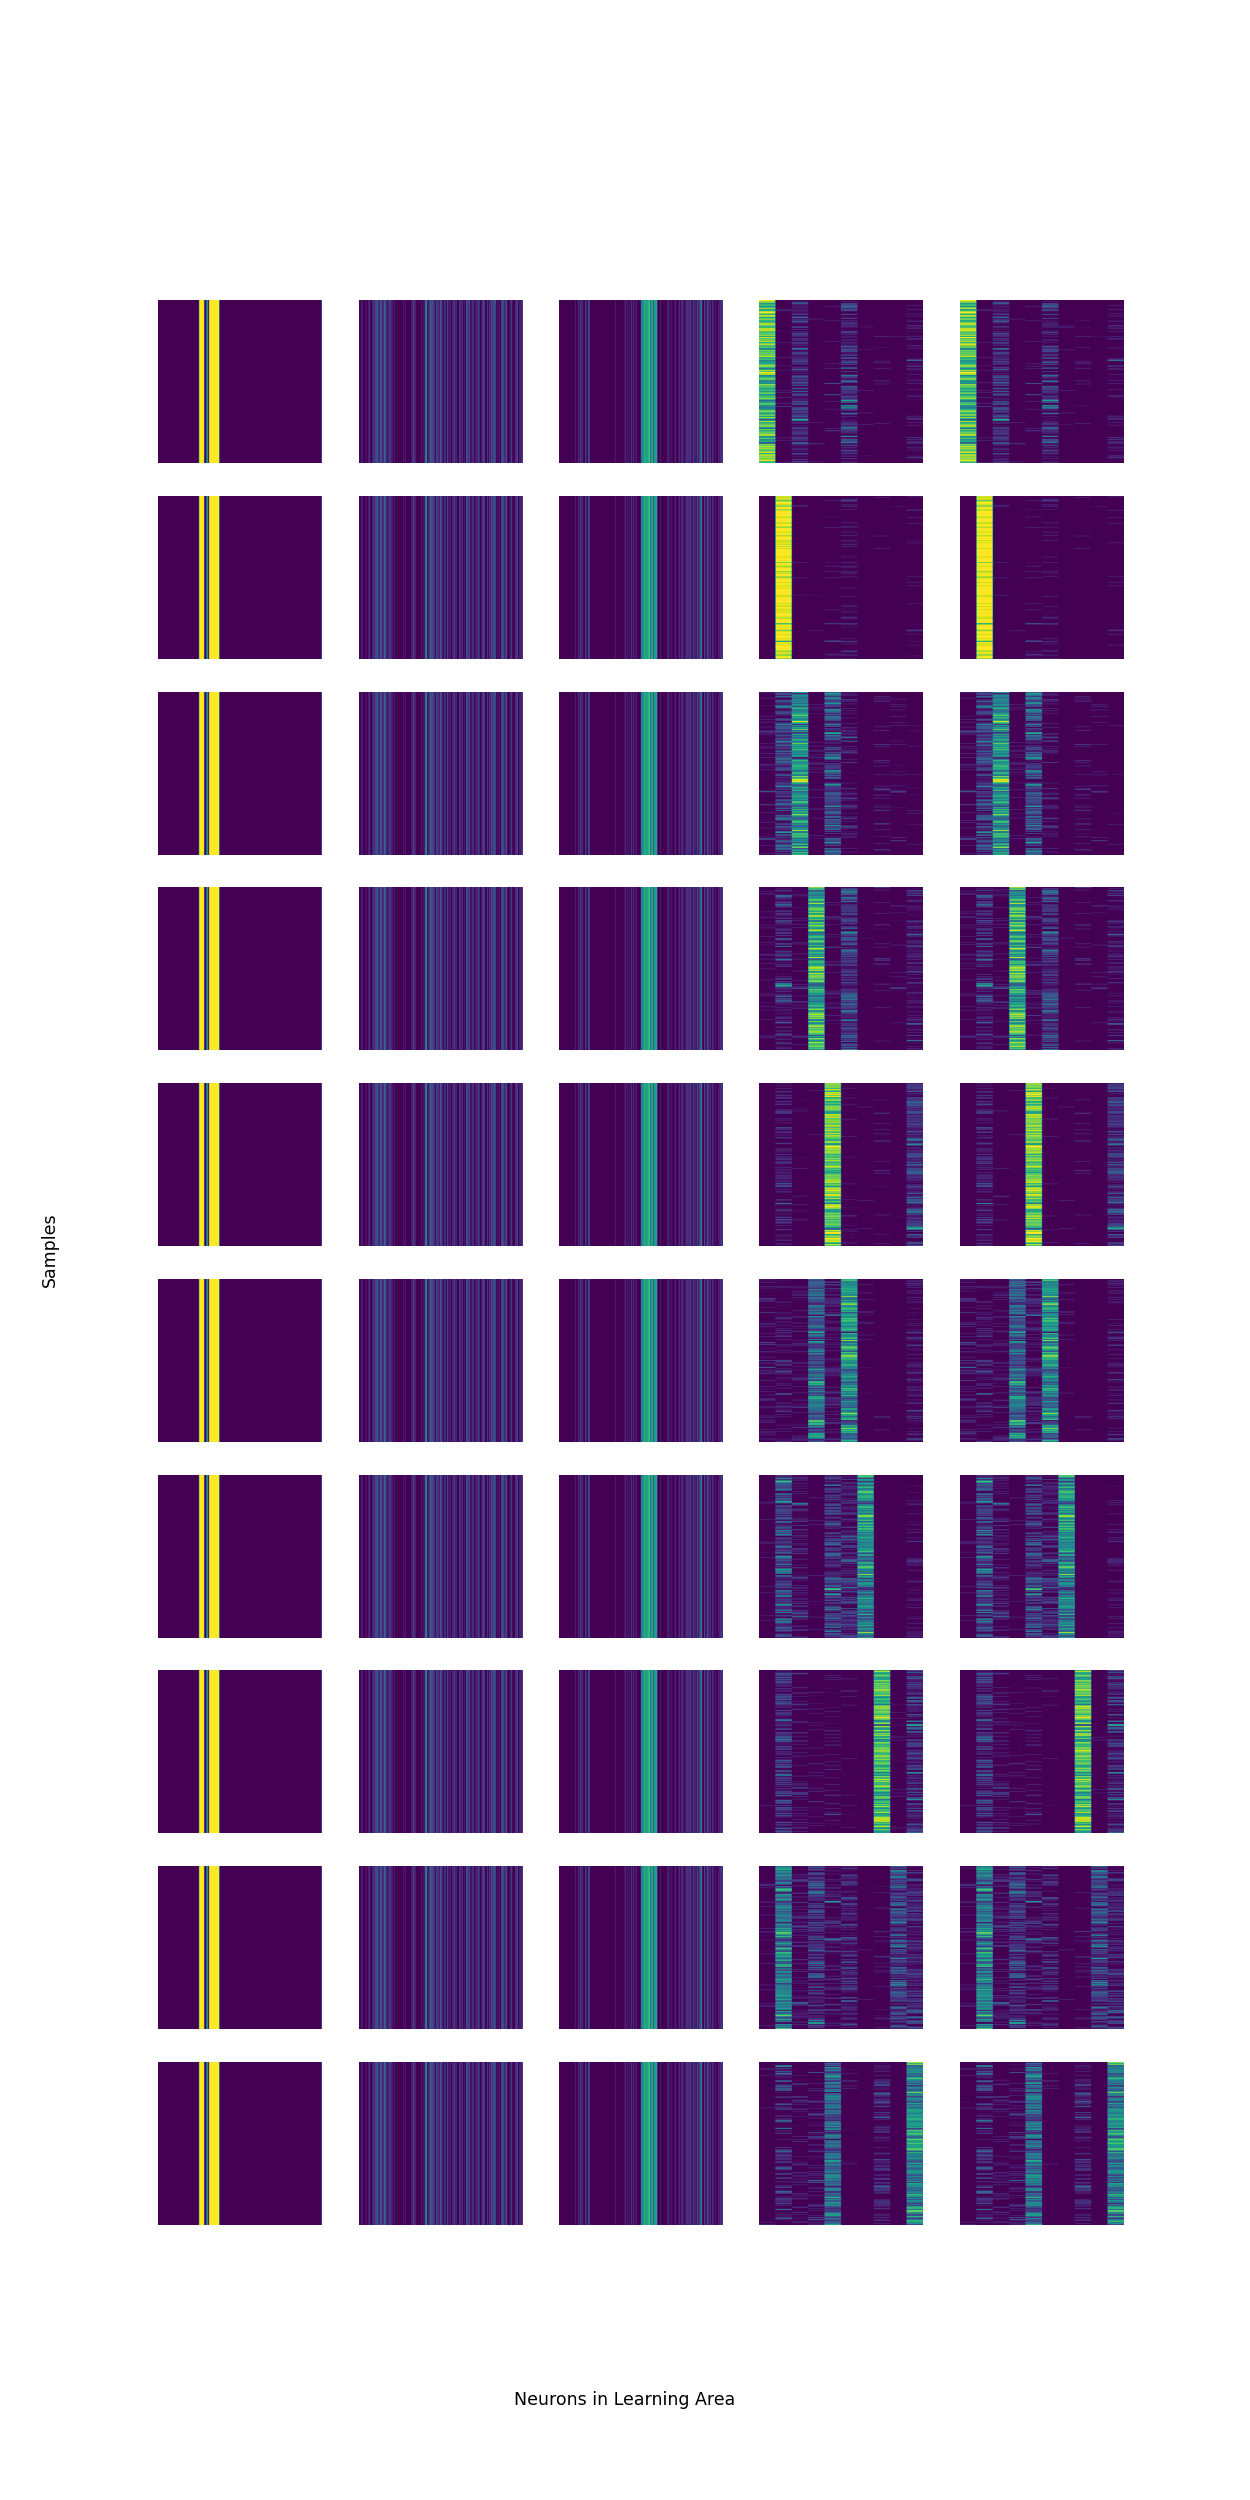

Text(0.04, 0.5, 'Samples')

In [243]:
fig, axes = plt.subplots(10, n_rounds, figsize=(10, 2 * 10), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:n_neurons, idx])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons in Learning Area', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

<IPython.core.display.Javascript object>


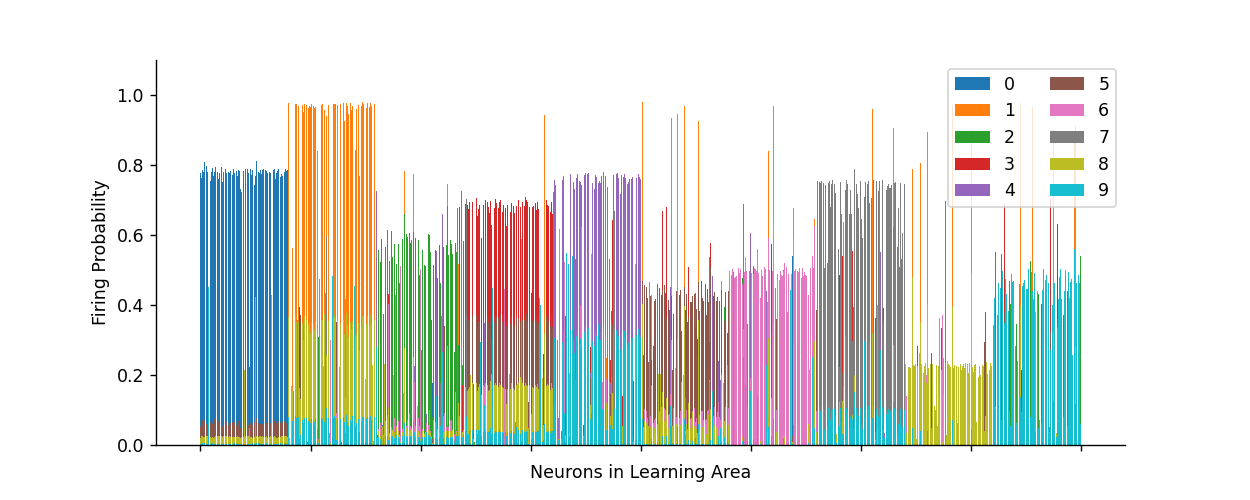

Text(0, 0.5, 'Firing Probability')

In [244]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(10):
    # Pass each sample to the model and get its result
    ax.bar(np.arange(n_neurons), act_l[i, -1].mean(axis=0)[idx_l], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons in Learning Area')
ax.set_ylabel('Firing Probability')

<IPython.core.display.Javascript object>


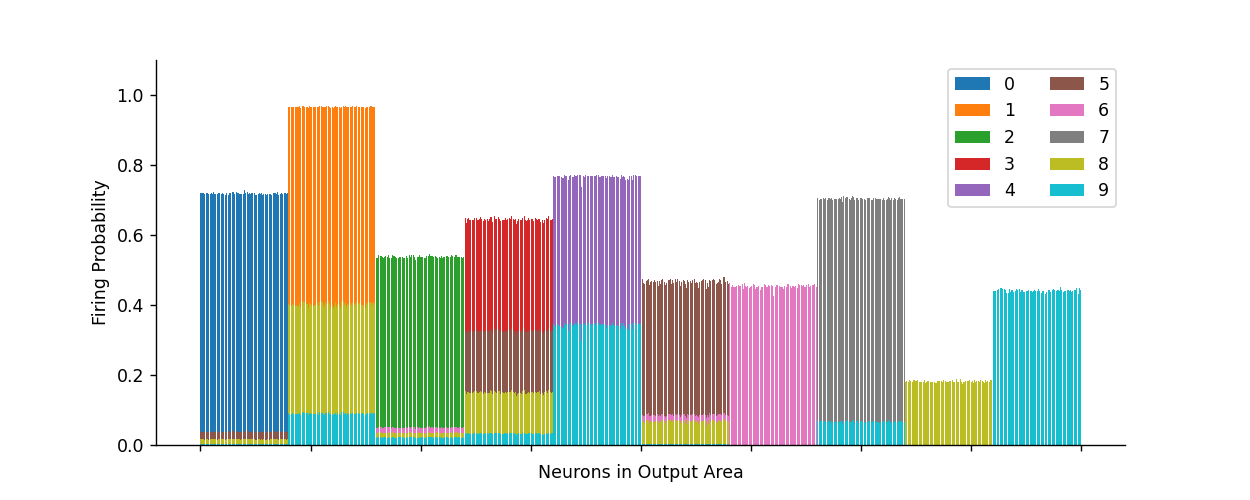

Text(0, 0.5, 'Firing Probability')

In [245]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(10):
    # Pass each sample to the model and get its result 
    ax.bar(np.arange(n_neurons), outputs[i, -1].mean(axis=0)[idx], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons in Output Area')
ax.set_ylabel('Firing Probability')

In [39]:
# We know the assembly of the output area by construction
c = np.zeros((10, n_neurons))
for i in range(10):
    c[i, i*cap_size: i*cap_size+cap_size] = 1

In [40]:
# outputs (10, n_rounds+1, n_examples, n_neurons)
predictions = (outputs[:, -1] @ c.T).argmax(axis=-1)
acc = (predictions == np.arange(10)[:, np.newaxis]).sum(axis=-1) / n_examples

In [41]:
acc, acc.mean()

(array([0.7642, 0.9838, 0.5342, 0.6734, 0.748 , 0.398 , 0.5742, 0.7182,
        0.239 , 0.5574]),
 0.61904)